# Part 0: DB connections, filepaths etc.

In [1]:
experiment_name = 'CDR'
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# %run init.py

print "Setting up variables & DB connection for experiment:\n"
print "*******************\n%s\n*******************"%experiment_name

# point to appropriate DBs, pickle files etc.
pkl_paths = 'pickles/%s/'%experiment_name
path_candidate_dict_pkl = pkl_paths+ 'candidate_dict.pickle' # TODO rename that
path_pubmed_ids_pkl = pkl_paths + 'pubmed_ids.pickle'
path_base_learners = pkl_paths + 'base_learner_predictions' # TODO create dirs


# Shortcuts to connect to database, initialize candidate subclass and return snorkel session
import os
#TODO: set experiment_name and restructure dir
os.environ['SNORKELDB'] = 'postgres:///snorkel'+experiment_name

from snorkel import SnorkelSession
session = SnorkelSession()
from snorkel.models import  Document, Sentence
import matplotlib.pyplot as plt
from snorkel.annotations import save_marginals
from snorkel.models import Candidate, candidate_subclass
ChemicalDisease = candidate_subclass('ChemicalDisease', ['chemical', 'disease'])

print "\nSnorkel session connected to: ",os.environ['SNORKELDB']

Setting up variables & DB connection for experiment:

*******************
CDR
*******************

Snorkel session connected to:  postgres:///snorkelCDR


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


# Part I: Corpus Preprocessing


In [3]:
import os
from snorkel.parser import XMLMultiDocPreprocessor

# The following line is for testing only. Feel free to ignore it.
file_path = 'data/CDR.BioC.small.xml' if 'CI' in os.environ else 'data/CDR.BioC.xml'

doc_preprocessor = XMLMultiDocPreprocessor(
    path=file_path,
    doc='.//document',
    text='.//passage/text/text()',
    id='.//id/text()'
)

In [4]:
from snorkel.parser import CorpusParser
# from utils import TaggerOneTagger
from snorkel.utils_cdr import TaggerOneTagger, CDRTagger
from snorkel.parser.spacy_parser import Spacy


tagger_one = TaggerOneTagger()
corpus_parser = CorpusParser(fn=tagger_one.tag, parser=Spacy())
corpus_parser.apply(list(doc_preprocessor))

Clearing existing...
Running UDF...
[========================================] 100%



In [5]:
from snorkel.models import Document, Sentence

print("Documents:", session.query(Document).count())
print("Sentences:", session.query(Sentence).count())

('Documents:', 1500L)
('Sentences:', 14593L)


# Part II: Candidate Extraction

In [6]:
# modified to implement random splitting of (official training set) to D_B & D_U
from six.moves.cPickle import load
import random
seed = 448
random.seed(seed)


with open('data/doc_ids.pkl', 'rb') as f:
    train_off_ids, dev_ids, test_ids = load(f)
dev_ids, test_ids = set(dev_ids), set(test_ids)

#split train_ids into D_B & D_U 
random.shuffle(train_off_ids)
train_ids = set(train_off_ids[:300]) # This will be D_B
unlab_ids = set(train_off_ids[300:]) # This will be D_U
print( len(train_ids), len(dev_ids), len(test_ids), len(unlab_ids))

train_sents, dev_sents, test_sents, unlab_sents = set(), set(), set(), set()
docs = session.query(Document).order_by(Document.name).all()
for i, doc in enumerate(docs):
    for s in doc.sentences:
        if doc.name in train_ids:
            train_sents.add(s)
        elif doc.name in dev_ids:
            dev_sents.add(s)
        elif doc.name in test_ids:
            test_sents.add(s)
        elif doc.name in unlab_ids:
            unlab_sents.add(s)
        else:
            raise Exception('ID <{0}> not found in any id set'.format(doc.name))

print(len(train_sents), len(dev_sents), len(test_sents),len(unlab_sents))

(300, 100, 500, 600)
(2940, 920, 5056, 5677)


# Candidate extraction

In [7]:
from snorkel.candidates import PretaggedCandidateExtractor

candidate_extractor = PretaggedCandidateExtractor(ChemicalDisease, ['Chemical', 'Disease'])

In [8]:
for k, sents in enumerate([train_sents, dev_sents, test_sents, unlab_sents]):
    candidate_extractor.apply(sents, split=k)
    print("Number of candidates:", session.query(ChemicalDisease).filter(ChemicalDisease.split == k).count())

Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 2860L)
Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 920L)
Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 4680L)
Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 5576L)


# Load gold labels

In [20]:
from load_external_annotations import load_external_labels
from snorkel.annotations import load_gold_labels

for splt in range(4):
    load_external_labels(session, ChemicalDisease, split=splt, annotator='gold')

AnnotatorLabels created: 2860
AnnotatorLabels created: 920
AnnotatorLabels created: 0
AnnotatorLabels created: 5576


In [19]:
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)
L_gold_test

<4680x1 sparse matrix of type '<type 'numpy.int64'>'
	with 4680 stored elements in Compressed Sparse Row format>

In [21]:
L_gold_test.nnz

4680

In [77]:
from utils import check_class_imbalance

In [87]:
check_class_imbalance(L_gold_test.data)

-1    0.676282
 1    0.323718
dtype: float64

In [22]:
from snorkel.models import StableLabel
from sqlalchemy import and_

In [24]:
for k in range(4):
    print 'split = ',k
    print 'Total cands:', session.query(ChemicalDisease).filter(ChemicalDisease.split == k).count()
    print 'Mapped cands:', session.query(ChemicalDisease).filter(ChemicalDisease.split == k).filter(ChemicalDisease.gold_labels).count()
    print 'Un-mapped cands:', session.query(ChemicalDisease).filter(ChemicalDisease.split == k).filter(~ChemicalDisease.gold_labels.any()).count()
    print session.query(ChemicalDisease).filter(ChemicalDisease.split == k).count() == (session.query(ChemicalDisease).filter(ChemicalDisease.split == k).filter(ChemicalDisease.gold_labels).count() +
                                                                           session.query(ChemicalDisease).filter(ChemicalDisease.split == k).filter(~ChemicalDisease.gold_labels.any()).count())
    print ''


 split =  0
Total cands: 2860
Mapped cands: 2860
Un-mapped cands: 0
True

split =  1
Total cands: 920
Mapped cands: 920
Un-mapped cands: 0
True

split =  2
Total cands: 4680
Mapped cands: 4680
Un-mapped cands: 0
True

split =  3
Total cands: 5576
Mapped cands: 5576
Un-mapped cands: 0
True



#### Exporting candidates from snorkel to sklearn for ML model training

In [62]:
from sklearn_bridge import export_snorkel_candidates

In [63]:
# export candidates for train, dev, test dataset
candidates = dict()
nr_cands_extracted=0
for i in range(4): #for train,dev,test export only labelled candidates 
    candidates[i] = export_snorkel_candidates(session,ChemicalDisease, i, True)
    print 'Extracted %i candidates from split = %i '%(len(candidates[i].keys()), i)
    nr_cands_extracted += len(candidates[i].keys())

print 'Extracted %i candidates in total'%nr_cands_extracted

Extracted 2860 candidates from split = 0 
Extracted 920 candidates from split = 1 
Extracted 4680 candidates from split = 2 
Extracted 5576 candidates from split = 3 
Extracted 14036 candidates in total


In [64]:
print "Saving to: %s"%path_candidate_dict_pkl

Saving to: pickles/CDR/candidate_dict.pickle


In [65]:
with open(path_candidate_dict_pkl, 'wb') as f:
    pickle.dump(dict(candidates),f)

# #########################################
# Once this is done, results are persisted into snorkel.db and this step is no longer required, unless more documents are added.
# #########################################

# -------------------------------
# Part 1A (training the Base Learners)
# -------------------------------

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

In [32]:
# Rebuild text representation
from sklearn_bridge import recreate_text_representation, candidate_dict_to_df

In [33]:
from MLutils import report_to_df, train_evaluate, diversity_heatmap

In [34]:
import sklearn, pickle, time, seaborn
import pandas as pd
from itertools import product

In [66]:
with open(path_candidate_dict_pkl, 'rb') as f:
    candidate_dict = pickle.load(f)

for splt in candidate_dict.keys():
    print "Split = %i : imported %i candidates" %(splt, len(candidate_dict[splt].keys()))

Split = 0 : imported 2860 candidates
Split = 1 : imported 920 candidates
Split = 2 : imported 4680 candidates
Split = 3 : imported 5576 candidates


In [67]:
# Set pipeline options
shortest_dep_paths = [True, False] #  TODO also add shortest_dep_path
trimmings = [(False,0),
             (True,0), 
             (True, 5)
            ]
use_lemmas_ = [True, 
               #False
              ]
random_undersample_ = [True]
text_vectorizer_ = [CountVectorizer(binary=True, min_df=5, stop_words='english'),
                    #CountVectorizer(binary=True, min_df=1 , stop_words=None),
                    CountVectorizer(binary=True, min_df=5 , ngram_range=(0,3)),
                    
# #                    CountVectorizer(binary=True, min_df=5 , stop_words='english'),
                    TfidfVectorizer(binary=False, min_df=5 , stop_words='english'),
                    #TfidfVectorizer(binary=False, min_df=1 , stop_words=None ),
                    TfidfVectorizer(binary=False, min_df=5, ngram_range=(0,3) ),
# #                     TfidfVectorizer(binary=True, min_df=5 , stop_words='english'),
                   ]

lsa_dims = [200, None]

In [69]:
# select models to train
models = {
    'LogisticRegression': LogisticRegression(),
    'SVC_linear': SVC(kernel = 'linear'),
# # # #     'SVC_rbf': SVC(kernel = 'rbf'),
    'SVC_rbf_C=75': SVC(kernel = 'rbf', C=75),
    'SVC_rbf_C=150': SVC(kernel = 'rbf', C=150),
    'SVC_rbf_C=250': SVC(kernel = 'rbf', C=250),
# #     'kNN_5': KNeighborsClassifier(),
# #     'kNN_25': KNeighborsClassifier(n_neighbors=25),
# #     'kNN_2': KNeighborsClassifier(n_neighbors=2),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=100, max_depth=5),
# #     'NeuralNet(10,10)' : MLPClassifier(hidden_layer_sizes=(10,10)),
# #     'BernoulliNB': BernoulliNB(),
}


In [70]:
combs = product(trimmings,use_lemmas_, random_undersample_, text_vectorizer_, lsa_dims, shortest_dep_paths )
combs = list(combs)
print len(combs)*len(models)


288


#### Deep Neural Nets as base learners
Additionally, we need to train the LSTM and the CNN.


For this, we need to run the following files:

* CNN-text-classification-keras.ipynb 
* baseline/snorkel baseline LSTM pred.ipynb

# Perform training 

In [71]:
import imblearn
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
# import numpy as np
from scipy.sparse import hstack
from MLutils import get_positive_logit, logits_to_bin_labels, logits_to_neg_labels, classif_report_from_dicts

In [88]:
debug=False
start_time = time.time()
for comb in combs: 
    
    #pass pipeline selections
    (trim_text,trim_window) = comb[0]
    use_lemmas = comb[1]
    random_undersample = comb[2]
    text_vectorizer = comb[3]
    lsa_dims = comb[4]
    shortest_dep_path = comb[5]
    
    # determine name
    pkl_name = 'results_dict,'
    if shortest_dep_path:
        pkl_name += 'ShortDepPath,'
    elif trim_text:
        pkl_name += 'trim='+str(trim_window)+','
    if use_lemmas:
        pkl_name += 'lemmas'+','
    if random_undersample:
        pkl_name += ',RuS'+','
    #CV, TFIDF
    if isinstance(text_vectorizer, TfidfVectorizer):
        pkl_name += ',TfIdf_'+','
    elif isinstance(text_vectorizer, CountVectorizer):
        pkl_name += ',CV_'+','      
    if text_vectorizer.binary:
        pkl_name += 'bin_'+','
    if text_vectorizer.min_df:
        pkl_name += 'minFreq='+str(text_vectorizer.min_df)+','
    if text_vectorizer.stop_words:
        pkl_name += '_stopw='+str(text_vectorizer.stop_words)+','
    if text_vectorizer.ngram_range:
        pkl_name += '_ngrams='+str(text_vectorizer.ngram_range)+','
    if lsa_dims:
        pkl_name += ',LSA'+str(lsa_dims)+','
    pkl_name = pkl_name.replace(',,',',')
    
    # Debug pkl name
    if debug:
        print pkl_name
        continue
    
    
    print 'Saving as: \n'+pkl_name.strip(',')+'.pkl'
    print time.time() - start_time
    print ''
    
    if os.path.isfile(path_base_learners+'/'+pkl_name+'.pkl'):
        
        print pkl_name,"exists, skipping . . ."
        continue
    
    if shortest_dep_path:
        #reload from pickle df_train,val,test etc
        try:
            with open(path_base_learners+'/sdp/SDP_df_TrainValTestUnlab.pickle' , 'rb') as f:
                (df_train, df_val, df_test, df_unlab) = pickle.load(f)
        except:
            # create it and save it
            df_train = candidate_dict_to_df(candidate_dict[0],trim_text=False, window=0, lemmas = True ,shortest_dep_path = shortest_dep_path)
            df_val = candidate_dict_to_df(candidate_dict[1],trim_text=False, window=0, lemmas =  True ,shortest_dep_path = shortest_dep_path )
            df_test = candidate_dict_to_df(candidate_dict[2],trim_text=False, window=0, lemmas = True ,shortest_dep_path = shortest_dep_path)
            df_unlab = candidate_dict_to_df(candidate_dict[3],trim_text=False, window=0, lemmas = True ,shortest_dep_path = shortest_dep_path)
            with open(path_base_learners+'/sdp/SDP_df_TrainValTestUnlab.pickle' , 'wb') as f:
                pickle.dump((df_train, df_val, df_test, df_unlab),f)
    else:
        # create train/test set
        df_train = candidate_dict_to_df(candidate_dict[0],trim_text=trim_text, window=trim_window, lemmas = use_lemmas ,shortest_dep_path = shortest_dep_path)
        df_val = candidate_dict_to_df(candidate_dict[1],trim_text=trim_text, window=trim_window, lemmas =  use_lemmas,shortest_dep_path = shortest_dep_path )
        df_test = candidate_dict_to_df(candidate_dict[2],trim_text=trim_text, window=trim_window, lemmas = use_lemmas ,shortest_dep_path = shortest_dep_path)
        df_unlab = candidate_dict_to_df(candidate_dict[3],trim_text=trim_text, window=trim_window, lemmas = use_lemmas ,shortest_dep_path = shortest_dep_path)
    
    
    # get indices (only for val, test, unlab) to zip with results in a dict
    val_ids = list(df_val.index)
    test_ids = list(df_test.index)
    unlab_ids = list(df_unlab.index)
    
    
    
    #TODO: move random undersampling here (will fasten up algorithm)
    
    # text 2 matrix (CV/TF-idf)
    X_train = text_vectorizer.fit_transform(df_train.text)
    y_train = df_train.label
    

    X_val = text_vectorizer.transform(df_val.text)
#     y_val = df_val.label # To delete    
    
    X_test = text_vectorizer.transform(df_test.text)
#     y_test = df_test.label # To delete
    
    X_unlab = text_vectorizer.transform(df_unlab.text)
#     y_unlab = df_unlab.label # To delete
    
    
    #new
    y_val_gold = dict(df_val.label)
    y_test_gold = dict(df_test.label)
    
    
    # LSA
    if lsa_dims: #TODO save in diff. matrix to append later?
        svd = TruncatedSVD(n_components=lsa_dims)
        X_train_svd = svd.fit_transform(X_train)
        X_val_svd = svd.transform(X_val)
        X_test_svd = svd.transform(X_test)
        X_unlab_svd = svd.transform(X_unlab)
        
        
        if True:#TODO replace with concat keyword
            X_train = hstack((X_train,X_train_svd))
            X_val = hstack((X_val,X_val_svd))
            X_test = hstack((X_test,X_test_svd))
            X_unlab = hstack((X_unlab,X_unlab_svd))
    
    # undersampling
    if random_undersample:
#         print('Original dataset shape {}'.format(Counter(y_train)))
        rus = RandomUnderSampler(random_state=42)
        X_train, y_train = rus.fit_sample(X_train, y_train)
#         print('Resampled dataset shape {}'.format(Counter(y_train)))

    # train/predict, construct results_dict
    results_dict = dict()
    for model_name,model in models.iteritems():
        print 'Training',model_name
#         start_time = time.time()

        try:
            model.probability = True
        except:
            pass
        
        #train & predict
        model.fit(X_train,y_train)
        positive_class_position = list(model.classes_).index(1) #either 0 or 1, depending on model.classes_ (used to get + logits)
                
        logits = model.predict_proba(X_val)
        y_val_pred_pos_logit = dict(zip(val_ids, get_positive_logit(logits, positive_class_position)))
        y_val_pred_neg = dict(zip(val_ids, logits_to_neg_labels(logits))) #only used for evaluation
        
        #save classif report
        class_report = report_to_df(
            classif_report_from_dicts(y_val_gold, y_val_pred_neg)
                                 )
        print class_report
        
        if class_report.loc['1','f1-score']<0.5:
            continue
        
        # perform predictions for the rest of the data
        logits = model.predict_proba(X_test)
        y_test_pred_pos_logit = dict(zip(test_ids, get_positive_logit(logits, positive_class_position)))
        
        logits = model.predict_proba(X_unlab)
        y_unlab_pred_pos_logit = dict(zip(unlab_ids, get_positive_logit(logits, positive_class_position)))
        
#         To delete
#         logits = model.predict()
#         y_test_pred_pos_logit = dict(zip(test_ids, get_positive_logit(logits)))
#         y_test_pred_bin = dict(zip(val_ids, logits_to_bin_labels(logits))) #only used for evaluation
#         y_test_pred_neg = dict(zip(val_ids, logits_to_neg_labels(logits))) #only used for evaluation
        
        
        # TODO: do smth for later, when true lbls not in place.
        
        results_dict[model_name] = {
                                    "label_val_prob+" : y_val_pred_pos_logit,
                                   "label_test_prob+" : y_test_pred_pos_logit,
                                   "label_unlab_prob+" : y_unlab_pred_pos_logit,
                                    "classification_report": class_report,
                                    "f1+": class_report.loc['1','f1-score']
                                   }
#         print "%s done. (%.2f sec)"%(model_name,time.time()-start_time)
    #save predictions in dict
    
    with open(path_base_learners+'/'+pkl_name+'.pkl', 'wb') as f:
        pickle.dump(results_dict,f)
        
#     diversity_heatmap(results_dict, title = pkl_name)

Saving as: 
results_dict,ShortDepPath,lemmas,RuS,CV_,bin_,minFreq=5,_stopw=english,_ngrams=(1, 1),LSA200.pkl
0.00162291526794

Training LogisticRegression
           precision  recall  f1-score  support
Classes                                        
-1              0.75    0.66      0.70      614
1               0.45    0.55      0.49      306
avg/total       0.65    0.62      0.63      920
Training SVC_rbf_C=250
           precision  recall  f1-score  support
Classes                                        
-1              0.75    0.67      0.71      614
1               0.45    0.56      0.50      306
avg/total       0.65    0.63      0.64      920
Training RandomForestClassifier
           precision  recall  f1-score  support
Classes                                        
-1              0.72    0.79      0.75      614
1               0.47    0.37      0.41      306
avg/total       0.63    0.65      0.64      920
Training SVC_linear
           precision  recall  f1-score  support
Cl

Training SVC_rbf_C=150
           precision  recall  f1-score  support
Classes                                        
-1              0.78    0.64      0.70      614
1               0.47    0.65      0.55      306
avg/total       0.68    0.64      0.65      920
Saving as: 
results_dict,lemmas,RuS,CV_,bin_,minFreq=5,_ngrams=(0, 3),LSA200.pkl
195.900989771

Training LogisticRegression
           precision  recall  f1-score  support
Classes                                        
-1              0.74    0.64      0.69      614
1               0.43    0.55      0.48      306
avg/total       0.64    0.61      0.62      920
Training SVC_rbf_C=250
           precision  recall  f1-score  support
Classes                                        
-1              0.74    0.65      0.69      614
1               0.44    0.55      0.49      306
avg/total       0.64    0.62      0.63      920
Training RandomForestClassifier
           precision  recall  f1-score  support
Classes                       

           precision  recall  f1-score  support
Classes                                        
-1              0.69    0.58      0.63      614
1               0.37    0.49      0.42      306
avg/total       0.58    0.55      0.56      920
Training SVC_rbf_C=150
           precision  recall  f1-score  support
Classes                                        
-1              0.69    0.54      0.60      614
1               0.35    0.51      0.42      306
avg/total       0.58    0.53      0.54      920
Saving as: 
results_dict,ShortDepPath,lemmas,RuS,TfIdf_,minFreq=5,_stopw=english,_ngrams=(1, 1).pkl
396.669467926

Training LogisticRegression
           precision  recall  f1-score  support
Classes                                        
-1              0.77    0.58      0.66      614
1               0.43    0.64      0.52      306
avg/total       0.65    0.60      0.61      920
Training SVC_rbf_C=250
           precision  recall  f1-score  support
Classes                                    

/home/antonis/anaconda2/envs/snorkel27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


           precision  recall  f1-score  support
Classes                                        
-1              0.00    0.00      0.00      614
1               0.33    1.00      0.50      306
avg/total       0.11    0.33      0.17      920
Training SVC_rbf_C=150
           precision  recall  f1-score  support
Classes                                        
-1              0.73    0.78      0.75      614
1               0.49    0.42      0.45      306
avg/total       0.65    0.66      0.65      920
Saving as: 
results_dict,ShortDepPath,lemmas,RuS,TfIdf_,minFreq=5,_ngrams=(0, 3).pkl
548.173787832

Training LogisticRegression
           precision  recall  f1-score  support
Classes                                        
-1              0.79    0.65      0.72      614
1               0.49    0.66      0.56      306
avg/total       0.69    0.66      0.66      920
Training SVC_rbf_C=250
           precision  recall  f1-score  support
Classes                                        
-1        

           precision  recall  f1-score  support
Classes                                        
-1              0.77    0.58      0.66      614
1               0.44    0.65      0.52      306
avg/total       0.66    0.60      0.61      920
Training RandomForestClassifier
           precision  recall  f1-score  support
Classes                                        
-1              0.74    0.66      0.70      614
1               0.44    0.53      0.48      306
avg/total       0.64    0.62      0.63      920
Training SVC_linear
           precision  recall  f1-score  support
Classes                                        
-1              0.78    0.60      0.67      614
1               0.45    0.66      0.53      306
avg/total       0.67    0.62      0.63      920
Training SVC_rbf_C=75
           precision  recall  f1-score  support
Classes                                        
-1              0.77    0.57      0.66      614
1               0.43    0.66      0.52      306
avg/total     

Training SVC_rbf_C=75
           precision  recall  f1-score  support
Classes                                        
-1              0.76    0.72      0.74      614
1               0.50    0.55      0.52      306
avg/total       0.68    0.67      0.67      920
Training SVC_rbf_C=150
           precision  recall  f1-score  support
Classes                                        
-1              0.77    0.68      0.72      614
1               0.47    0.58      0.52      306
avg/total       0.67    0.65      0.65      920
Saving as: 
results_dict,ShortDepPath,lemmas,RuS,TfIdf_,minFreq=5,_ngrams=(0, 3).pkl
849.429516792

results_dict,ShortDepPath,lemmas,RuS,TfIdf_,minFreq=5,_ngrams=(0, 3), exists, skipping . . .
Saving as: 
results_dict,trim=0,lemmas,RuS,TfIdf_,minFreq=5,_ngrams=(0, 3).pkl
849.429691792

Training LogisticRegression
           precision  recall  f1-score  support
Classes                                        
-1              0.78    0.69      0.73      614
1               

Training LogisticRegression
           precision  recall  f1-score  support
Classes                                        
-1              0.77    0.65      0.70      614
1               0.46    0.61      0.53      306
avg/total       0.67    0.64      0.65      920
Training SVC_rbf_C=250
           precision  recall  f1-score  support
Classes                                        
-1              0.77    0.63      0.69      614
1               0.45    0.61      0.52      306
avg/total       0.66    0.62      0.64      920
Training RandomForestClassifier
           precision  recall  f1-score  support
Classes                                        
-1              0.75    0.67      0.71      614
1               0.45    0.55      0.50      306
avg/total       0.65    0.63      0.64      920
Training SVC_linear
           precision  recall  f1-score  support
Classes                                        
-1              0.76    0.59      0.66      614
1               0.43    0.63     

           precision  recall  f1-score  support
Classes                                        
-1              0.75    0.57      0.65      614
1               0.42    0.61      0.49      306
avg/total       0.64    0.59      0.60      920
Training SVC_linear
           precision  recall  f1-score  support
Classes                                        
-1              0.77    0.69      0.72      614
1               0.48    0.58      0.52      306
avg/total       0.67    0.65      0.66      920
Training SVC_rbf_C=75
           precision  recall  f1-score  support
Classes                                        
-1              0.76    0.63      0.69      614
1               0.45    0.61      0.52      306
avg/total       0.66    0.62      0.63      920
Training SVC_rbf_C=150
           precision  recall  f1-score  support
Classes                                        
-1              0.74    0.85      0.79      614
1               0.57    0.39      0.46      306
avg/total       0.68   

# ----------->
# Open CNN-text-classification-keras-CDR and generate results for CNN

# -------------------------------
# Part 2 (snorkel LF)
# -------------------------------

In [3]:
import seaborn as sns
from snorkel.annotations import save_marginals

In [4]:
from snorkel.lf_helpers import *
import pickle,glob
import pandas as pd
from MLutils import cohen_kappa_score, plot_marginals_histogram, neg_to_bin_labels, diversity_heatmap, merge_pickles_pred_dicts


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [5]:
# load gold labels 
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)

In [6]:
# make sure unmapped cands are gone
from sqlalchemy import  any_,or_,and_
#create list of unmapped cands to drop
to_drop = []
for k in range(4):
    query = session.query(ChemicalDisease).filter(and_(ChemicalDisease.split==k,~ChemicalDisease.gold_labels.any()))
    print 'Adding %i candidates from split=%i in to_drop list'%(query.count(), k)
    to_drop.extend(map(lambda x: x.id,query.all()))

Adding 0 candidates from split=0 in to_drop list
Adding 0 candidates from split=1 in to_drop list
Adding 0 candidates from split=2 in to_drop list
Adding 0 candidates from split=3 in to_drop list


### Load from pickles & DB

In [9]:
l = glob.glob(path_base_learners+"/KMeansPeaks/*.pickle")
l.sort()
l

['pickles/CDR/base_learner_predictions/KMeansPeaks/10clusters.pickle',
 'pickles/CDR/base_learner_predictions/KMeansPeaks/13clusters.pickle',
 'pickles/CDR/base_learner_predictions/KMeansPeaks/15clusters.pickle',
 'pickles/CDR/base_learner_predictions/KMeansPeaks/20clusters.pickle',
 'pickles/CDR/base_learner_predictions/KMeansPeaks/5clusters.pickle',
 'pickles/CDR/base_learner_predictions/KMeansPeaks/6clusters.pickle']

In [10]:
result_dict_file = l[0]
print "Proceeding with: ",result_dict_file

Proceeding with:  pickles/CDR/base_learner_predictions/KMeansPeaks/10clusters.pickle


In [11]:
with open(result_dict_file, 'rb') as f:
    results_dict = pickle.load(f)
print 'Loaded %i models:\n' %len(results_dict)
results_dict.keys()

Loaded 10 models:



['results_dict,ShortDepPath,lemmas,RuS,CV_,bin_,minFreq=5,_stopw=english,_ngrams=(1, 1)_SVC_linear',
 'results_dict,trim=0,lemmas,RuS,CV_,bin_,minFreq=5,_ngrams=(0, 3)_SVC_rbf_C=75',
 'results_dict,trim=5,lemmas,RuS,CV_,bin_,minFreq=5,_ngrams=(0, 3),LSA200_SVC_rbf_C=150',
 'results_dict,ShortDepPath,lemmas,RuS,TfIdf_,minFreq=5,_ngrams=(0, 3),LSA200_SVC_linear',
 'results_dict,ShortDepPath,lemmas,RuS,CV_,bin_,minFreq=5,_stopw=english,_ngrams=(1, 1)_RandomForestClassifier',
 'results_dict,lemmas,RuS,CV_,bin_,minFreq=5,_ngrams=(0, 3),LSA200_SVC_rbf_C=150',
 'results_dict,lemmas,RuS,TfIdf_,minFreq=5,_ngrams=(0, 3)_RandomForestClassifier',
 'results_dict,ShortDepPath,lemmas,RuS,TfIdf_,minFreq=5,_stopw=english,_ngrams=(1, 1),LSA200_LogisticRegression',
 'results_dict,lemmas,RuS,TfIdf_,minFreq=5,_ngrams=(0, 3),LSA200_SVC_rbf_C=75',
 'results_dict,trim=0,lemmas,RuS,CV_,bin_,minFreq=5,_stopw=english,_ngrams=(1, 1)_LogisticRegression']

In [12]:
selected_models = results_dict.keys()
selected_models.sort()

In [13]:
#Convert labels to -1,1....
for model in selected_models:
    results_dict[model]['label_unlab'] = dict(zip(results_dict[model]['label_unlab_prob+'].keys(),(np.array(results_dict[model]['label_unlab_prob+'].values())>=0.5)*2-1))
    results_dict[model]['label_val'] = dict(zip(results_dict[model]['label_val_prob+'].keys(),(np.array(results_dict[model]['label_val_prob+'].values())>=0.5)*2-1))
#     results_dict[model]['label_train'] = dict(zip(results_dict[model]['label_train_prob+'].keys(),(np.array(results_dict[model]['label_val_prob+'].values())>=0.5)*2-1))
    results_dict[model]['label_test'] = dict(zip(results_dict[model]['label_test_prob+'].keys(),(np.array(results_dict[model]['label_test_prob+'].values())>=0.5)*2-1))

In [14]:
bl_scores = []
for model in results_dict.keys():
    bl_scores.append(results_dict[model]['f1+'])

In [15]:
from MLutils import balance_candidates, sample_from_csr, majority_vote, majority_vote_score, average_vote, error_analysis

In [16]:
# load unlabeled set labels (for exp3)
L_gold_unlab = load_gold_labels(session, annotator_name='gold', split=3)

In [17]:
L_gold_train = load_gold_labels(session, annotator_name='gold', split=0)

### Port results into snorkel

In [18]:
from MLutils import diversity_matrix, reduce_results_dict
from sklearn.metrics import accuracy_score, cohen_kappa_score
from snorkel.annotations import LabelAnnotator

In [19]:
# Include the results for validation data
def signal_annotator_unlab_val(c):
    """A generator over the different (worker_id, label_id) pairs for a Tweet."""
    for model in results_dict.keys():
        try:
            yield model, results_dict[model]['label_unlab'][c.id]
            
        except:
            try:
                yield model, results_dict[model]['label_val'][c.id]
            except:
                yield model, results_dict[model]['label_test'][c.id]

labeler = LabelAnnotator(label_generator=signal_annotator_unlab_val)

In [20]:
#regenerate L_unlab - Takes about 1h for 12 voters (100% coverage)

%time L_unlab = labeler.apply(split=3, parallelism=6)
L_unlab

Clearing existing...
Running UDF...
CPU times: user 1min, sys: 3.02 s, total: 1min 3s
Wall time: 3min 38s


<5576x10 sparse matrix of type '<type 'numpy.int64'>'
	with 55760 stored elements in Compressed Sparse Row format>

In [21]:
# load validation & test set & their labels (to compute majority votes etc)
L_dev = labeler.apply_existing(split=1, parallelism=6)
L_test = labeler.apply_existing(split=2, parallelism=6)

Clearing existing...
Running UDF...
Clearing existing...
Running UDF...


In [22]:
#TODO? : save scr in pickle for analysis

In [23]:
from utils import check_class_imbalance

** Check maj voting  ** 


Predicted class imbalance by maj voting:
1.0    0.502869
0.0    0.397238
0.5    0.099892
dtype: float64


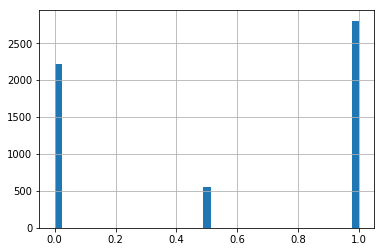

In [24]:
maj_vote_labels = majority_vote(L_unlab)
pd.Series(maj_vote_labels).hist(bins=41)
print "\nPredicted class imbalance by maj voting:"
print check_class_imbalance(maj_vote_labels)

In [25]:
print "Majority voting (val set):\n"
print majority_vote_score(L_dev, L_gold_dev)
print "Majority voting (test set):\n"
print majority_vote_score(L_test, L_gold_test)

Majority voting (val set):

(0.45871559633027525, 0.6535947712418301, 0.5390835579514824)
Majority voting (test set):

(0.47194432361896477, 0.7161716171617162, 0.5689564761405348)


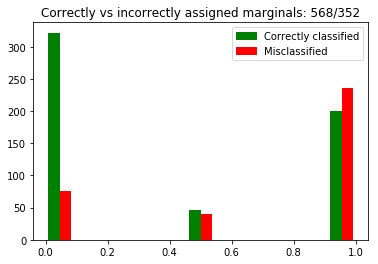

In [26]:
error_analysis(L_dev, L_gold_dev, majority_voting=True)

** Check avg voting **

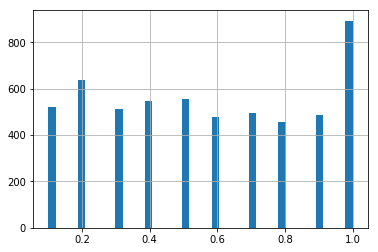

In [27]:
# get average of votes based on the preds of base classifiers
avg_vote_labels = average_vote(L_unlab)
pd.Series(avg_vote_labels).hist(bins=41)

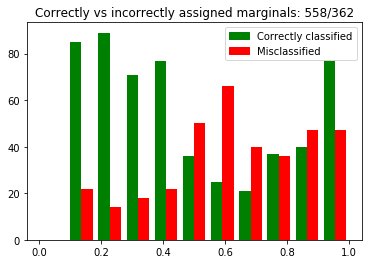

In [28]:
error_analysis(L_dev, L_gold_dev, average_voting=True)

In [29]:
# # save avg vote labels as toy example for the new eval metric
# with open(pkl_paths+"new_eval_metric/13models_avg_voting_labels.pkl", 'wb') as f:
#     pickle.dump(avg_vote_labels, f)

### Denoising

#### Find dependencies between LFs


In [30]:
from itertools import combinations

In [31]:
from snorkel.learning.structure import DependencySelector
ds = DependencySelector()

In [32]:
# Generate all possible dependencies with threshold from 0 to 0.15
all_deps = [ds.select(L_unlab, threshold=thresh) for thresh in np.array(range(0.1,15.1,2.5))/100.]
print list(map(lambda x: len(x) ,all_deps))
all_deps = list(np.unique(all_deps)) # delete duplicates for gridsearch
print list(map(lambda x: len(x) ,all_deps))

print "Maximum nr of dependencies: %i" %len(list(combinations(L_dev.col_index.values(),2)))

[45, 44, 39, 35, 25, 21, 17, 16]
[16, 17, 21, 25, 35, 39, 44, 45]
Maximum nr of dependencies: 45


#### GM training

In [33]:
from snorkel.learning import RandomSearch, GenerativeModel, GridSearch

In [34]:
param_ranges = { # parameters for the train function of the GenerativeModel
    'step_size' : [10./L_unlab.shape[0],
                  1./L_unlab.shape[0],
                   20./L_unlab.shape[0],
                   0.1/L_unlab.shape[0],
                  ],
    'decay' : [0.99,0.95],
    'epochs' : [100],
    'reg_param': [.5 , 1, 3, 7, 1e2 ,1e5 , 1e10, 1e20 ],
    'deps': all_deps
}

model_class_params = {  # parameters for the GenerativeModel
    'lf_propensity': [True]
}

searcher = RandomSearch(GenerativeModel, param_ranges,  L_unlab, model_class_params = model_class_params , n=24 )
# searcher = GridSearch(GenerativeModel, param_ranges,  L_unlab, model_class_params = model_class_params  )


In [35]:
%%time

try:
    del run_stats
except:
    pass

gen_model, run_stats = searcher.fit(L_dev, L_gold_dev, n_threads=6 )

Loading data...
Launching jobs...
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
[GenerativeModel] Model saved as <GenerativeModel_0>.
[GenerativeModel] Model saved as <GenerativeModel_1>.
Inferred cardinality: 2
Model 0 Done; score: 0.511822059281
[GenerativeModel] Model saved as <GenerativeModel_2>.
Inferred cardinality: 2
Model 1 Done; score: 0.511188220372
Inferred cardinality: 2
Model 2 Done; score: 0.511555860017
[GenerativeModel] Model saved as <GenerativeModel_5>.
[GenerativeModel] Model saved as <GenerativeModel_4>.
[GenerativeModel] Model saved as <GenerativeModel_3>.
Inferred cardinality: 2
Model 5 Done; score: 0.511800371508
Inferred cardinality: 2
Model 4 Done; score: 0.511601284784
Inferred cardinality: 2
Model 3 Done; score: 0.51109521304
[GenerativeModel] Model saved as <GenerativeModel_7>.
[GenerativeModel] Model saved as <GenerativeModel_6>.
Inferred cardinality: 2
Model 7

** Do some analysis on generative model results **

In [36]:
run_stats['#deps'] = list(map(lambda x: len(run_stats.deps[x]), run_stats.index)) # save # deps to identify 'deps'

In [37]:
new_scores = {"Prec.": "F-1",
 "Rec.": "Weighted Log Loss",
 "F-1": "Average Precision"
}

In [38]:
print "Generative Model params:\n"
GM_eval = run_stats.drop('deps', axis=1).rename(new_scores,axis=1)
GM_eval

Generative Model params:



,Model,epochs,step_size,reg_param,decay,F-1,Weighted Log Loss,Average Precision,#deps
14,13,100,0.000179,3.000000e+00,0.95,0.539084,-3.440359,0.512173,39
22,22,100,0.000018,1.000000e+02,0.95,0.539084,-3.502840,0.512128,35
21,21,100,0.001793,7.000000e+00,0.99,0.539084,-3.489415,0.512117,21
23,23,100,0.000179,1.000000e+02,0.95,0.539084,-3.502830,0.512032,45
9,9,100,0.003587,7.000000e+00,0.99,0.543011,-3.487039,0.512010,35
11,11,100,0.000179,1.000000e+02,0.99,0.539084,-3.502738,0.511954,25
10,10,100,0.000018,3.000000e+00,0.99,0.539084,-3.458693,0.511940,16
13,14,100,0.001793,1.000000e+02,0.99,0.539084,-3.504200,0.511918,16
20,20,100,0.003587,1.000000e+00,0.95,0.542282,-3.193768,0.511856,39
0,0,100,0.003587,7.000000e+00,0.95,0.539084,-3.488427,0.511822,35


[GenerativeModel] Model <GenerativeModel_18> loaded.
F-1                  0.545939
Weighted Log Loss   -2.895386
Average Precision    0.511720
Name: 17, dtype: float64


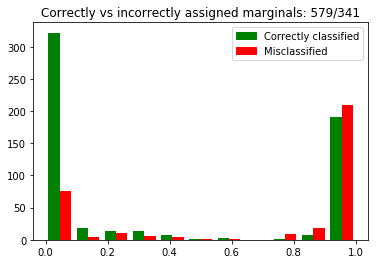


************************************

[GenerativeModel] Model <GenerativeModel_16> loaded.
F-1                  0.545939
Weighted Log Loss   -2.900171
Average Precision    0.511750
Name: 16, dtype: float64


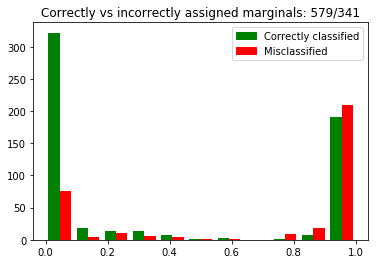


************************************

[GenerativeModel] Model <GenerativeModel_4> loaded.
F-1                  0.545939
Weighted Log Loss   -2.784839
Average Precision    0.511601
Name: 4, dtype: float64


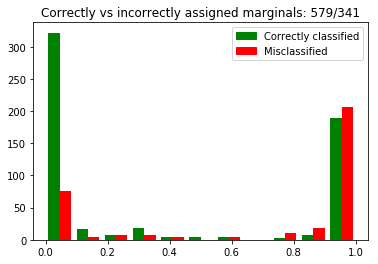


************************************

[GenerativeModel] Model <GenerativeModel_5> loaded.
F-1                  0.545939
Weighted Log Loss   -2.797867
Average Precision    0.511800
Name: 3, dtype: float64


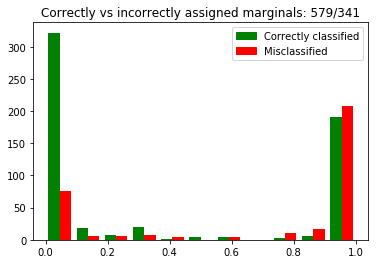


************************************

[GenerativeModel] Model <GenerativeModel_9> loaded.
F-1                  0.543011
Weighted Log Loss   -3.487039
Average Precision    0.512010
Name: 9, dtype: float64


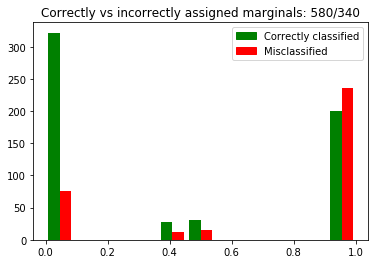


************************************



In [39]:
for row in GM_eval.sort_values("F-1",ascending=False)[:5].iterrows():
#     print row,'\n'
    i=row[1]['Model']
    gm = GenerativeModel()
    gm.load("GenerativeModel_%i"%i,save_dir="checkpoints/grid_search/")
    print row[1][['F-1','Weighted Log Loss', 'Average Precision']]
    error_analysis(L_dev, L_gold_dev, gen_model=gm)
    plt.show()
    print "\n************************************\n"

#### Save marginals and proceed to LSTM training

In [40]:
unlab_marginals_gen = gen_model.marginals(L_unlab)
unlab_marginals_avg = average_vote(L_unlab)
unlab_marginals_maj = majority_vote(L_unlab)

In [41]:
# # saving marginals for reproduc

# for lbls,name in zip([unlab_marginals_avg,unlab_marginals_gen,unlab_marginals_maj], ['unlab_marginals_avg','unlab_marginals_gen','unlab_marginals_maj'], ):
#     with open(pkl_paths+"6_models/"+name, 'wb') as f:
#         print "Dumping %s"%name
#         pickle.dump(lbls, f)

In [42]:
# # Load marginals 

# marginals = {}

# for i,name in enumerate(['unlab_marginals_avg','unlab_marginals_gen','unlab_marginals_maj'], ):
#     with open(pkl_paths+"6_models/"+name, 'rb') as f:
#         print "Loading %s"%name
#         marginals[i]= pickle.load( f)


# -------------------------------
# Meta-Learner training
# -------------------------------

In [43]:
from MLutils import balance_candidates

In [44]:
from snorkel.learning import reRNN

In [45]:
# needed to train the LSTM here
train = session.query(ChemicalDisease).filter(ChemicalDisease.split == 0).order_by(ChemicalDisease.id).all()
dev = session.query(ChemicalDisease).filter(ChemicalDisease.split == 1).order_by(ChemicalDisease.id).all()
test = session.query(ChemicalDisease).filter(ChemicalDisease.split == 2).order_by(ChemicalDisease.id).all()
unlab = session.query(ChemicalDisease).filter(ChemicalDisease.split == 3).order_by(ChemicalDisease.id).all()

In [47]:
# if I get them from pickle
# unlab_marginals_avg , unlab_marginals_gen, unlab_marginals_maj= marginals[0],marginals[1], marginals[2]

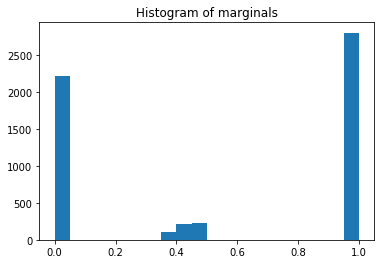

In [48]:
plot_marginals_histogram(unlab_marginals_gen, 
                         title = 'Histogram of marginals' ,
                        bins = 20)

In [49]:
# just to make sure that it keeps consistency
train_labels = np.array([0 if train[x].gold_labels[0].value ==-1 else 1 for x in range(len(train))]) # load train labels to mix in LSTM
dev_labels = np.array([0 if dev[x].gold_labels[0].value ==-1 else 1 for x in range(len(dev))]) # load train labels to mix in LSTM
test_labels = np.array([0 if test[x].gold_labels[0].value ==-1 else 1 for x in range(len(test))]) # load train labels to mix in LSTM

In [50]:
# unlab_us,unlab_marginals_us = balance_candidates(unlab,unlab_marginals)

# # TODO: balance candidates also in training set (change train_unlab_marginals below + train -> train_us in lstm.train)
train_us, train_labels_us = balance_candidates(train,train_labels)

train_unlab_marginals = np.append(train_labels_us, unlab_marginals_gen)

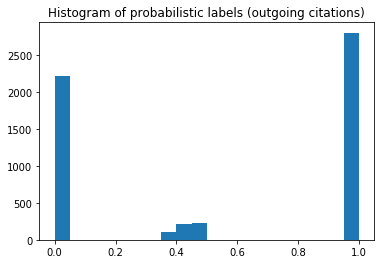

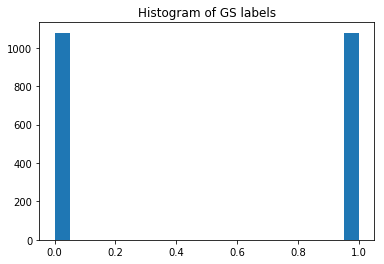

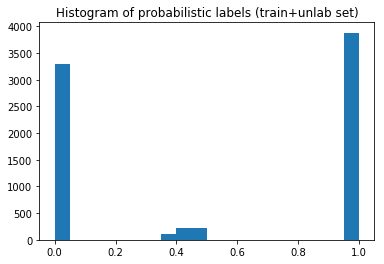

In [51]:
import matplotlib.pyplot as plt
plt.hist(unlab_marginals_gen, bins=20, range=[0,1])
plt.title('Histogram of probabilistic labels (outgoing citations)')
plt.show()

import matplotlib.pyplot as plt
plt.hist(train_labels_us, bins=20, range=[0,1])
plt.title('Histogram of GS labels')
plt.show()

# plt.hist(unlab_marginals_us, bins=20, range=[0,1])
# plt.title('Histogram of probabilistic labels (unlab set, undersampled)')
# plt.show()

# plt.hist(train_labels_us, bins=20)
# plt.title('Histogram of labels (train set)')
# plt.show()

plt.hist(train_unlab_marginals, bins=20)
plt.title('Histogram of probabilistic labels (train+unlab set)')
plt.show()


### Train on unlab

In [52]:
# GM marginals

In [53]:
train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   20,
    'dropout':    0.25,
    'rebalance':  True,
    'print_freq': 1,
    'batch_size': 64,
    'dev_ckpt_delay': 0
}

lstm = reRNN(seed=1701, deterministic=False)
lstm.train(unlab, unlab_marginals_gen, X_dev=dev, Y_dev=L_gold_dev, **train_kwargs)

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=5544  #epochs=20  batch size=64
[reRNN] Epoch 0 (23.10s)	Average loss=0.582698	Dev F1=50.13
[reRNN] Epoch 1 (46.22s)	Average loss=0.390139	Dev F1=48.20
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (71.30s)	Average loss=0.300019	Dev F1=49.10
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 3 (97.43s)	Average loss=0.238246	Dev F1=50.68
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 4 (123.15s)	Average loss=0.196714	Dev F1=47.14
[reRNN] Epoch 5 (147.24s)	Average loss=0.177200	Dev F1=50.33
[reRNN] Epoch 6 (171.33s)	Average loss=0.158022	Dev F1=48.80
[reRNN] Epoch 7 (195.21s)	Average loss=0.138847	Dev F1=48.09
[reRNN] Epoch 8 (219.50s)	Average loss=0.130410	Dev F1=49.86
[reRNN] Epoch 9 (243.96s)	Average loss=0.125862	Dev F1=47.44
[reRNN] Epoch 10 (269.30s)	Average loss=0.134346	Dev F1=51.57
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 11 (295.00s)	Average loss=0.131104	Dev F1=49.43
[reRNN] Epoch 12 (320.10s)	Average loss=0.123656	Dev F1=50.90
[reRNN] Epoch

In [54]:
print(lstm.score(dev,dev_labels))
print(lstm.score(test,L_gold_test,batch_size=1024))
tp, fp, tn, fn = lstm.error_analysis(session, test, L_gold_test, batch_size = 1024)

(0.4393305439330544, 0.6862745098039216, 0.5357142857142857)
(0.4374255065554231, 0.7267326732673267, 0.5461309523809523)
Scores (Un-adjusted)
Pos. class accuracy: 0.727
Neg. class accuracy: 0.553
Precision            0.437
Recall               0.727
F1                   0.546
----------------------------------------
TP: 1101 | FP: 1416 | TN: 1749 | FN: 414



In [55]:
# AVG vote marginals

In [56]:
lstm = reRNN(seed=1701, deterministic=False)
lstm.train(unlab, unlab_marginals_avg, X_dev=dev, Y_dev=L_gold_dev, **train_kwargs)

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=4430  #epochs=20  batch size=64
[reRNN] Epoch 0 (19.04s)	Average loss=0.619438	Dev F1=48.85
[reRNN] Epoch 1 (38.98s)	Average loss=0.537402	Dev F1=50.55
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (60.70s)	Average loss=0.503541	Dev F1=50.88
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 3 (82.05s)	Average loss=0.486839	Dev F1=49.93
[reRNN] Epoch 4 (102.04s)	Average loss=0.473276	Dev F1=50.42
[reRNN] Epoch 5 (122.09s)	Average loss=0.466883	Dev F1=51.09
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 6 (144.28s)	Average loss=0.462105	Dev F1=51.00
[reRNN] Epoch 7 (165.65s)	Average loss=0.459292	Dev F1=52.87
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 8 (187.68s)	Average loss=0.454317	Dev F1=53.41
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 9 (209.51s)	Average loss=0.455392	Dev F1=52.13
[reRNN] Epoch 10 (229.76s)	Average loss=0.451962	Dev F1=50.35
[reRNN] Epoch 11 (249.91s)	Average loss=0.449488	Dev F1=53.81
[reRNN] Model saved as <reRNN>
[reRNN] Epoch

In [57]:
print(lstm.score(dev,dev_labels))
print(lstm.score(test,L_gold_test,batch_size=1024))
tp, fp, tn, fn = lstm.error_analysis(session, test, L_gold_test, batch_size = 1024)

(0.44421906693711966, 0.7156862745098039, 0.5481852315394242)
(0.4369846878680801, 0.7346534653465346, 0.5480059084194978)
Scores (Un-adjusted)
Pos. class accuracy: 0.735
Neg. class accuracy: 0.547
Precision            0.437
Recall               0.735
F1                   0.548
----------------------------------------
TP: 1113 | FP: 1434 | TN: 1731 | FN: 402



In [58]:
# MV labels

In [59]:
lstm = reRNN(seed=1701, deterministic=False)
lstm.train(unlab, unlab_marginals_maj, X_dev=dev, Y_dev=L_gold_dev, **train_kwargs)

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=4430  #epochs=20  batch size=64
[reRNN] Epoch 0 (20.70s)	Average loss=0.580761	Dev F1=45.95
[reRNN] Epoch 1 (41.38s)	Average loss=0.358725	Dev F1=47.35
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (64.08s)	Average loss=0.244471	Dev F1=48.06
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 3 (86.26s)	Average loss=0.175845	Dev F1=47.98
[reRNN] Epoch 4 (106.89s)	Average loss=0.128555	Dev F1=48.97
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 5 (128.23s)	Average loss=0.096781	Dev F1=49.63
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 6 (149.67s)	Average loss=0.073912	Dev F1=51.70
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 7 (170.68s)	Average loss=0.059598	Dev F1=50.68
[reRNN] Epoch 8 (190.70s)	Average loss=0.062671	Dev F1=50.34
[reRNN] Epoch 9 (210.33s)	Average loss=0.040222	Dev F1=50.68
[reRNN] Epoch 10 (230.07s)	Average loss=0.031681	Dev F1=50.30
[reRNN] Epoch 11 (249.58s)	Average loss=0.041124	Dev F1=51.08
[reRNN] Epoch 12 (269.11s)	Average loss=0.03

In [60]:
print('@ Validation',lstm.score(dev,dev_labels))
print('@ Test',lstm.score(test,L_gold_test,batch_size=1024))
tp, fp, tn, fn = lstm.error_analysis(session, test, L_gold_test, batch_size = 1024)

('@ Validation', (0.43043478260869567, 0.6470588235294118, 0.5169712793733682))
('@ Test', (0.4272618573136708, 0.7075907590759076, 0.5328031809145128))
Scores (Un-adjusted)
Pos. class accuracy: 0.708
Neg. class accuracy: 0.546
Precision            0.427
Recall               0.708
F1                   0.533
----------------------------------------
TP: 1072 | FP: 1437 | TN: 1728 | FN: 443



In [61]:
############

## Paper stuff (scores etc)

In [62]:
print("Base Learner scores stats:\n(min,mean,max)")
print(np.min(bl_scores), 
np.mean(bl_scores),
np.max(bl_scores))

Base Learner scores stats:
(min,mean,max)
(0.5, 0.514, 0.56)


In [63]:
majority_vote_score(L_test, L_gold_test)

(0.47194432361896477, 0.7161716171617162, 0.5689564761405348)

In [64]:
gen_model.score(L_test,L_gold_test)

(0.5689564761405348, -3.197528120314428, 0.5409314628376962)

### Train on GS + unlab
# NOT NEEDED for paper rev

In [102]:
# train_kwargs = {
#     'lr':         0.01,
#     'dim':        100,
#     'n_epochs':   30,
#     'dropout':    0.25,
#     'rebalance':  True,
#     'print_freq': 1,
#     'batch_size': 64,
#     'dev_ckpt_delay': 0
# }

# lstm = reRNN(seed=1701, deterministic=True)
# lstm.train(train+unlab, 
#            np.concatenate([train_labels ,unlab_marginals_gen]),
#            X_dev=dev, Y_dev=L_gold_dev, **train_kwargs)


In [103]:
# tp, fp, tn, fn = lstm.error_analysis(session, dev, L_gold_dev)

In [104]:
# tp, fp, tn, fn = lstm.error_analysis(session, test, L_gold_test, batch_size = 1024)

In [105]:
# lstm.score(test,L_gold_test,batch_size=1024)